## Target Predicting Functions: Linear Regression (LR), Support Vector Regressor(SVR) and Random Forest Regressor (RF). RF provides feature ranking using built-in ranking functions, as well as add-feature ranking algorithm

In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 


In [2]:
def run_random_search_pipeline(X, y):
    
    
#     n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]
#     grid = {'bootstrap': [True],
#                    'max_depth': [5, 10, None],
#     #                'max_features': ['auto', 'sqrt'],
#                    'min_samples_leaf': [1, 2, 4],
#     #                'min_samples_split': [2, 5, 10],
#                    'n_estimators': n_estimators}

    n_estimators = [20,50,100]
    grid = {'bootstrap': [True],
                   'max_depth': [5, 10, None],
    #                'max_features': ['auto', 'sqrt'],
                   'min_samples_leaf': [2],
    #                'min_samples_split': [2, 5, 10],
                   'n_estimators': n_estimators}
    
#     pipeline = make_pipeline(RandomForestRegressor())
    model=RandomForestRegressor(random_state=0)

    reg_RF = GridSearchCV(model, grid, cv = KFold(n_splits=3, shuffle=True), \
                         verbose = 3, n_jobs = -1, return_train_score=True)
    reg_RF.fit(X, y)
#     estimator.get_params().keys()
    scores_lim = pd.DataFrame(reg_RF.cv_results_)

    scores_lim = scores_lim[['params','mean_test_score','std_test_score','mean_train_score', 'mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)
    
    return scores_lim['mean_test_score']

In [3]:
def calculate_r_score(column_names, X):
    x_new = X[list(column_names)]
    # print(column_names)
    r_square = run_random_search_pipeline(x_new, y)
    
    return r_square.max()

In [4]:
def print_results(max_col_names, max_col_rscores):
    k= 1
    for i, j in zip(max_col_names, max_col_rscores):
        print("\t", k, i,j)
        k +=1

In [5]:
def calc_ith_iteration(max_col_names, max_col_rscores, orj_column_names, i, X):
    r_score_dict = {}
    for column_names in tqdm(orj_column_names): # orj_column_names = original column names
        # count += 1
        # print(count, max_col_names , column_names)
        feature_list = max_col_names + [column_names]
        r_score = calculate_r_score(feature_list, X)
        r_score_dict[column_names] = r_score
    
    max_col_names.append(max(r_score_dict, key=r_score_dict.get))
    max_col_rscores.append(max(r_score_dict.values()))
    # print("asdfasd", max_col_names[len(max_col_names) - 1])
    
    orj_column_names.remove(max_col_names[len(max_col_names) - 1])
    
    return max_col_names, max_col_rscores, orj_column_names, r_score_dict

In [6]:
def target_predicting_LR_function(X, y, params = {}):
    '''This function takes in a dataframe of X(features) and y (a target) and outputs predictions of the 
    target through Linear Regression model'''
    
        
    reg = LinearRegression() # choose the model: Linear Regression
    reg.fit(X, y) # fit the data to the chosen model
    # predict y (galaxy sizes) by using 5-fold cross-validation
    y_pred_LR = cross_val_predict(reg, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10))
    # find prediction scores of each of the cross validation fold
    scores_reg = cross_validate(reg, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10),
                               return_train_score=True)
    print("LR Accuracy: %0.2f (+/- %0.2f)" % (scores_reg['test_score'].mean(), scores_reg['test_score'].std() * 2))
    # Plot the figure
    fig_prediction, ax = plt.subplots(figsize=(5, 5))
    label = 'Train score={} \n Test score={}'.format(round(scores_reg['train_score'].mean(), 2),round(scores_reg['test_score'].mean(), 2) )
    ax = plt.subplot()
    ax.scatter(y, y_pred_LR, s=3, marker='.', alpha=0.7, label=label)
#     ax.set_xlim([0.0,100])
#     ax.set_ylim([0.0,100])
    ax.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
    ax.set_title('Prediction vs True Value with LR, all features ')
    ax.set_xlabel('True Galaxy Size/Halo Size')
    ax.set_ylabel(' Predicted Galaxy Size/Halo Size')
    ax.legend(loc='lower right')

    fig_prediction.tight_layout()
#         plt.savefig('Linear Regression results.jpg', dpi=500)
    plt.show()
    
    return y_pred_LR, fig_prediction

In [7]:
def target_predicting_SVR_function(X, y, params = {}):
    '''This function takes in a dataframe of X(features) and y (a target) and outputs predictions of the 
    target through Support Vector Regressior model'''
    
        
    start_time = time.time()

    piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

    piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

    #optimizing SVR

    parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale'], 'svr__C':[1000], \
              }

    model = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 3, n_jobs = -1, return_train_score=True)

    model.fit(X, y)

    print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the GridSearchCV for SVR: {elapsed_time:.3f} seconds")
    
    best_SVR=model.best_estimator_
    best_SVR_trainscore=model.cv_results_['mean_train_score'][model.best_index_]
    scores_SVR = cross_val_score(best_SVR, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10)) 
    y_pred_SVR = cross_val_predict(best_SVR, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10))
    
    print("SVR Accuracy: %0.2f (+/- %0.2f)" % (scores_SVR.mean(), scores_SVR.std() * 2))
    # Plot the figure
    fig_prediction, ax = plt.subplots(figsize=(5, 5))
    label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore, 2),round(scores_SVR.mean(), 2) )    
    ax = plt.subplot()
    ax.scatter(y, y_pred_LR, s=3, marker='.', alpha=0.7, label=label)
#     ax.set_xlim([0.0,100])
#     ax.set_ylim([0.0,100])
    ax.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
    ax.set_title('Prediction vs True Value with SVR & 33 features ')
    ax.set_xlabel('True Galaxy Size/Halo Size')
    ax.set_ylabel(' Predicted Galaxy Size/Halo Size')
    ax.legend(loc='lower right')

    fig_prediction.tight_layout()
#         plt.savefig('Linear Regression results.jpg', dpi=500)
    plt.show()
    
    return y_pred_SVR, fig_prediction

In [8]:
def target_predicting_RF_function(X, y, params = {}):
    '''This function takes in a dataframe of X(features) and y (a target) and outputs predictions of the 
    target through the Random Forest Regressor ML model'''
    
        
    regr_RF = RandomForestRegressor(random_state=0)

    # number of trees in random forest
    n_estimators = [20,50,100]
    # create random grid
    grid = {'bootstrap': [True],
                   'max_depth': [5, 10, None],
    #                'max_features': ['auto', 'sqrt'],
                   'min_samples_leaf': [1, 2, 4],
    #                'min_samples_split': [2, 5, 10],
                   'n_estimators': n_estimators}
    # Grid search of parameters
    rfr_grid = GridSearchCV(estimator = regr_RF, param_grid = grid, cv = KFold(n_splits=5, shuffle=True), \
                         verbose = 1, n_jobs = -1, return_train_score=True)

    rfr_grid.fit(X, y)

    print('Best params, best score:', "{:.4f}".format(rfr_grid.best_score_), \
        rfr_grid.best_params_)
    # define trainscore according to best model
    best_RF=rfr_grid.best_estimator_ # The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.

    best_RF_trainscore=rfr_grid.cv_results_['mean_train_score'][rfr_grid.best_index_]

    # predict y (galaxy sizes) by using 5-fold cross-validation
    y_pred_RF = cross_val_predict(best_RF, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10))

    # find prediction scores of each of the cross validation fold
    scores_RF = cross_val_score(best_RF, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10))
    print("RF Accuracy: %0.2f (+/- %0.2f)" % (scores_RF.mean(), scores_RF.std() * 2))
    
    # Plot the figure
    fig_prediction, ax = plt.subplots(figsize=(5, 5))

    label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore, 2),round(scores_RF.mean(), 2) )
    ax = plt.subplot()
    ax.scatter(y, y_pred_RF, s=3, marker='.', alpha=0.7, label=label)
#     ax.set_xlim([0.0,100])
#     ax.set_ylim([0.0,100])
    ax.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
    ax.set_title('Prediction vs True Value with RF & all features ', fontsize=14)
    ax.set_xlabel('True Galaxy Size/Halo Size ', fontsize=12)
    ax.set_ylabel('Predicted Galaxy Size/Halo Size', fontsize=12)
    ax.legend(loc='lower right')

    fig_prediction.tight_layout()
    # plt.savefig('Prediction_vs_True.jpeg', dpi=500)

    plt.show()
        
    # Extract important features using built-in functions
    start_time = time.time()
    importances = rfr_grid.best_estimator_.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rfr_grid.best_estimator_.estimators_], axis=0)
    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")


    feature_names = X.columns

    forest_importances = pd.Series(importances, index=feature_names)

    fig_perm_import, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5))
    fig_perm_import.suptitle('TNG-SAM Feature Importances  ', fontsize=16, fontweight='bold')

    forest_importances.plot.bar(yerr=std, ax=ax1)
    ax1.set_title("Feature importances using Mean Decrease in Impurity")
    ax1.set_ylabel("Mean decrease in impurity")

    ### Feature Importances Permutation

    start_time = time.time()
    result = permutation_importance(
        rfr_grid.best_estimator_, X, y, n_repeats=10, random_state=0, n_jobs=-1
    )
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

    forest_importances = pd.Series(result.importances_mean, index=feature_names)

    forest_importances.plot.bar(yerr=result.importances_std, ax=ax2)
    ax2.set_title("Feature importances using Permutation Importances ")
    ax2.set_ylabel("Mean accuracy decrease")
    fig_perm_import.tight_layout()
    # plt.savefig("Feature_Importances_v2.jpeg", dpi=500)

    plt.show()

    df_perm_import=pd.DataFrame(forest_importances).sort_values(0, ascending=False)
    df_perm_import.to_csv('RF built in Feature Importances Permutation.csv', index=False)

    # Add-feature Ranking Method
    # Note: This step calls 4 funcitons: run_random_search_pipeline(X,y), calculate_r_score(column_names),
    # print_results(max_col_names, max_col_rscores), calc_ith_iteration(max_col_names, max_col_rscores, orj_column_names, i)

    column_names = X.columns
        
    # init
    
    max_col_names = [] # 
    max_col_rscores = []
    orj_column_names = list(X.columns)

    max_col_rscores

    # main 
    for i in range(1, len(orj_column_names)+1):
        max_col_names, max_col_rscores, orj_column_names, r_score_dict = \
            calc_ith_iteration(max_col_names, max_col_rscores, orj_column_names, i, X)

        print(f"{i}. iteration: ")
        print_results(max_col_names, max_col_rscores)
        if i==17: break

    df_max_r_scores = pd.DataFrame({
    'feature_number' : range(1,18),
    'features':max_col_names,
    'r_sq_score': max_col_rscores  })
    # Save the important feature ranking obtained by add-column method
    #df_max_r_scores.to_csv('Max r scores by add column method.csv', index=False)

    fig_add_feature=df_max_r_scores.plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                        legend=False, grid=True, 
                        xticks=range(0,18))
    fig_add_feature.set_title(label= 'R square score by add-feature method',fontsize=16)
    fig_add_feature.set_xlabel('Features',fontsize=16)
    fig_add_feature.set_ylabel('R score',fontsize=16)
    
#     fig_add_feature.get_figure().savefig('R score by add-feature method.jpg', dpi=500)

    plt.show()
    
    return y_pred_RF, fig_prediction, fig_perm_import, df_perm_import, df_max_r_scores, fig_add_feature
  

In [9]:
df_normalized_31 = pd.read_csv('Halo Mass Normalized Dataset w 31 features.csv')

In [10]:
df_normalized_31.loc[:, 'BulgeMstar_ratio'] = df_normalized_31.loc[:,'GalpropNormMbulge']/df_normalized_31.loc[:, 'GalpropNormMstar']

In [11]:
df_disks = df_normalized_31[df_normalized_31['BulgeMstar_ratio']<=0.15]

In [12]:
X = df_disks.drop(columns=['GalpropNormHalfRadius', 'BulgeMstar_ratio'])


y = df_disks.loc[:,'GalpropNormHalfRadius']

In [13]:
X.shape

(15717, 31)

In [14]:
y.shape

(15717,)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params, best score: 0.9878 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
RF Accuracy: 0.99 (+/- 0.00)


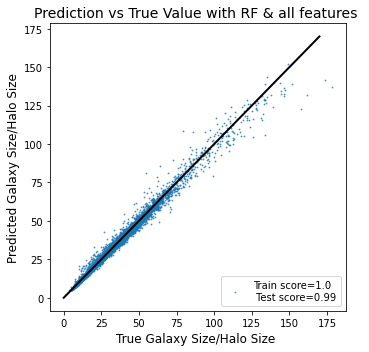

Elapsed time to compute the importances: 0.047 seconds
Elapsed time to compute the importances: 64.912 seconds


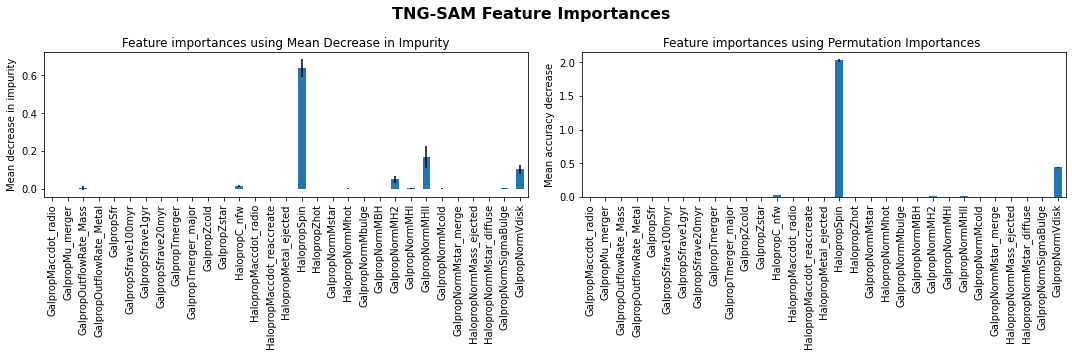

  0%|                                                    | 0/31 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▍                                          | 1/31 [00:01<00:37,  1.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▊                                         | 2/31 [00:04<01:04,  2.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▎                                       | 3/31 [00:06<01:06,  2.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▋                                      | 4/31 [00:09<01:04,  2.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 16%|███████                                     | 5/31 [00:11<01:04,  2.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▌                                   | 6/31 [00:14<01:02,  2.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|█████████▉                                  | 7/31 [00:16<00:59,  2.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▎                                | 8/31 [00:19<00:58,  2.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▊                               | 9/31 [00:21<00:51,  2.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|█████████████▊                             | 10/31 [00:23<00:45,  2.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▎                           | 11/31 [00:25<00:46,  2.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|████████████████▋                          | 12/31 [00:28<00:46,  2.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|██████████████████                         | 13/31 [00:31<00:47,  2.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▍                       | 14/31 [00:32<00:36,  2.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▊                      | 15/31 [00:35<00:38,  2.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▏                    | 16/31 [00:38<00:37,  2.51s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▌                   | 17/31 [00:40<00:35,  2.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|████████████████████████▉                  | 18/31 [00:43<00:34,  2.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████▎                | 19/31 [00:46<00:32,  2.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|███████████████████████████▋               | 20/31 [00:49<00:28,  2.62s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▏             | 21/31 [00:51<00:26,  2.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▌            | 22/31 [00:52<00:18,  2.11s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|███████████████████████████████▉           | 23/31 [00:55<00:18,  2.29s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|█████████████████████████████████▎         | 24/31 [00:57<00:16,  2.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▋        | 25/31 [01:00<00:14,  2.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 84%|████████████████████████████████████       | 26/31 [01:02<00:12,  2.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 87%|█████████████████████████████████████▍     | 27/31 [01:05<00:09,  2.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▊    | 28/31 [01:08<00:07,  2.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|████████████████████████████████████████▏  | 29/31 [01:09<00:04,  2.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▌ | 30/31 [01:12<00:02,  2.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 31/31 [01:14<00:00,  2.40s/it]


1. iteration: 
	 1 HalopropSpin 0.7146892745697956


  0%|                                                    | 0/30 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▍                                          | 1/30 [00:04<02:05,  4.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|██▉                                         | 2/30 [00:08<01:58,  4.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▍                                       | 3/30 [00:13<02:03,  4.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▊                                      | 4/30 [00:17<01:53,  4.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▎                                    | 5/30 [00:22<01:53,  4.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 20%|████████▊                                   | 6/30 [00:27<01:51,  4.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|██████████▎                                 | 7/30 [00:31<01:44,  4.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|███████████▋                                | 8/30 [00:36<01:42,  4.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████▏                              | 9/30 [00:40<01:33,  4.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▎                            | 10/30 [00:43<01:22,  4.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 37%|███████████████▊                           | 11/30 [00:47<01:17,  4.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▏                         | 12/30 [00:52<01:15,  4.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 43%|██████████████████▋                        | 13/30 [00:56<01:11,  4.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████                       | 14/30 [01:01<01:10,  4.40s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 15/30 [01:05<01:06,  4.40s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|██████████████████████▉                    | 16/30 [01:10<01:01,  4.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▎                  | 17/30 [01:15<00:59,  4.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|█████████████████████████▊                 | 18/30 [01:19<00:54,  4.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 63%|███████████████████████████▏               | 19/30 [01:24<00:51,  4.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 20/30 [01:28<00:45,  4.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.021, test=-0.000) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.028, test=-0.002) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.026, test=-0.010) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.026, test=-0.004) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.018, test=-0.003) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.067, test=-0.012) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.071, test=-0.009) total time=   0.4s
[CV 3/

 70%|██████████████████████████████             | 21/30 [01:34<00:42,  4.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.019, test=-0.003) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.024, test=-0.007) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.025, test=-0.008) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.026, test=-0.004) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.028, test=-0.010) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.017, test=-0.002) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.079, test=-0.012) total time=   0.7s
[CV 3/

 73%|███████████████████████████████▌           | 22/30 [01:39<00:38,  4.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.021, test=0.000) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.029, test=-0.005) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.029, test=-0.004) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.020, test=-0.002) total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.077, test=-0.007) total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.289, test=0.254) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.382, test=0.214) total time=   0.4s
[CV 3/3

 77%|████████████████████████████████▉          | 23/30 [01:44<00:35,  5.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.019, test=0.003) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.019, test=0.001) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.030, test=-0.004) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.019, test=-0.003) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.078, test=-0.009) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.071, test=-0.009) total time=   0.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.286, test=0.262) total time=   0.1s
[CV 3/3] END

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.019, test=0.004) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.027, test=-0.008) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.024, test=-0.007) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.028, test=-0.010) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.019, test=-0.002) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.078, test=-0.008) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.463, test=-0.255) total time=   0.8s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_es

 80%|██████████████████████████████████▍        | 24/30 [01:50<00:31,  5.29s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.018, test=0.002) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.027, test=-0.003) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.026, test=-0.005) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.027, test=-0.007) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.016, test=-0.002) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.076, test=-0.014) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.076, test=-0.014) total time=   0.4s
[CV 1/3] EN

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.019, test=0.004) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.026, test=-0.005) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.019, test=-0.002) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.019, test=-0.002) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.450, test=-0.262) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.470, test=-0.267) total time=   1.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.287, test=0.264) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_

 83%|███████████████████████████████████▊       | 25/30 [01:55<00:25,  5.11s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 87%|█████████████████████████████████████▎     | 26/30 [01:59<00:19,  4.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▋    | 27/30 [02:04<00:14,  4.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.019, test=0.002) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.028, test=-0.001) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.018, test=-0.003) total time=   0.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.457, test=-0.292) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.456, test=-0.231) total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.297, test=0.236) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.379, test=0.212) total time=   0.2s
[CV 3/3] 

 93%|████████████████████████████████████████▏  | 28/30 [02:09<00:09,  4.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▌ | 29/30 [02:13<00:04,  4.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 30/30 [02:18<00:00,  4.62s/it]


2. iteration: 
	 1 HalopropSpin 0.7146892745697956
	 2 GalpropNormVdisk 0.97828882373124


  0%|                                                    | 0/29 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▌                                          | 1/29 [00:06<03:03,  6.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|███                                         | 2/29 [00:13<02:59,  6.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▌                                       | 3/29 [00:19<02:51,  6.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|██████                                      | 4/29 [00:26<02:41,  6.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▌                                    | 5/29 [00:31<02:26,  6.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|█████████                                   | 6/29 [00:37<02:21,  6.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▌                                 | 7/29 [00:43<02:15,  6.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|████████████▏                               | 8/29 [00:50<02:10,  6.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 31%|█████████████▋                              | 9/29 [00:56<02:04,  6.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 34%|██████████████▊                            | 10/29 [01:02<01:53,  5.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▎                          | 11/29 [01:07<01:46,  5.91s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|█████████████████▊                         | 12/29 [01:13<01:42,  6.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▎                       | 13/29 [01:19<01:32,  5.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▊                      | 14/29 [01:25<01:28,  5.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▏                    | 15/29 [01:30<01:20,  5.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▋                   | 16/29 [01:37<01:17,  5.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▏                 | 17/29 [01:43<01:14,  6.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▋                | 18/29 [01:50<01:10,  6.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 66%|████████████████████████████▏              | 19/29 [01:57<01:03,  6.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 69%|█████████████████████████████▋             | 20/29 [02:03<00:57,  6.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|███████████████████████████████▏           | 21/29 [02:10<00:52,  6.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▌          | 22/29 [02:17<00:47,  6.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|██████████████████████████████████         | 23/29 [02:24<00:40,  6.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▌       | 24/29 [02:31<00:34,  6.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|█████████████████████████████████████      | 25/29 [02:38<00:27,  6.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▌    | 26/29 [02:44<00:20,  6.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.852, test=0.833) total time=   0.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.944, test=0.816) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.947, test=0.822) total time=   1.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.895, test=0.878) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.933, test=0.884) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.935, test=0.886) total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.963, test=0.873) total time=   0.9s
[CV 1/3] E

 93%|████████████████████████████████████████   | 27/29 [02:51<00:13,  6.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▌ | 28/29 [02:57<00:06,  6.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.881, test=0.813) total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.939, test=0.797) total time=   0.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.896, test=0.881) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.933, test=0.882) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.934, test=0.885) total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.961, test=0.877) total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.731, test=0.725) total time=   0.1s
[CV 2/3] END b

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.852, test=0.840) total time=   0.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.898, test=0.832) total time=   1.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.894, test=0.876) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.937, test=0.880) total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.961, test=0.878) total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.888, test=0.864) total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.931, test=0.876) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators

100%|███████████████████████████████████████████| 29/29 [03:03<00:00,  6.34s/it]


3. iteration: 
	 1 HalopropSpin 0.7146892745697956
	 2 GalpropNormVdisk 0.97828882373124
	 3 GalpropNormMHI 0.9823987219021784


  0%|                                                    | 0/28 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.830, test=0.812) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.883, test=0.813) total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.939, test=0.799) total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.890, test=0.881) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.933, test=0.884) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.936, test=0.883) total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.961, test=0.872) total time=   0.4s
[CV 2/3] END b

  4%|█▌                                          | 1/28 [00:07<03:10,  7.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.888, test=0.865) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.887, test=0.877) total time=   0.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.957, test=0.874) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.962, test=0.865) total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.831, test=0.812) total time=   0.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.936, test=0.795) total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.940, test=0.796) total time=   0.9s
[CV 1/3]

  7%|███▏                                        | 2/28 [00:15<03:18,  7.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.960, test=0.876) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.963, test=0.873) total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.883, test=0.883) total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.932, test=0.878) total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.961, test=0.864) total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.832, test=0.815) total time=   0.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.882, test=0.813) total time=   1.3s
[CV 1/3] 

 11%|████▋                                       | 3/28 [00:24<03:26,  8.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|██████▎                                     | 4/28 [00:33<03:24,  8.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.732, test=0.726) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.793, test=0.711) total time=   1.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.904, test=0.691) total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.730, test=0.722) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.783, test=0.697) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.778, test=0.718) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.874, test=0.653) total time=   0.8s
[CV 1/3] END

 18%|███████▊                                    | 5/28 [00:41<03:19,  8.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|█████████▍                                  | 6/28 [00:50<03:13,  8.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 7/28 [00:59<03:05,  8.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▌                               | 8/28 [01:08<02:57,  8.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|██████████████▏                             | 9/28 [01:16<02:41,  8.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|███████████████▎                           | 10/28 [01:22<02:20,  7.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|████████████████▉                          | 11/28 [01:31<02:18,  8.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 43%|██████████████████▍                        | 12/28 [01:40<02:14,  8.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 46%|███████████████████▉                       | 13/28 [01:48<02:04,  8.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 14/28 [01:56<01:54,  8.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 54%|███████████████████████                    | 15/28 [02:05<01:49,  8.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▌                  | 16/28 [02:14<01:42,  8.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████                 | 17/28 [02:23<01:35,  8.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|███████████████████████████▋               | 18/28 [02:30<01:23,  8.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▏             | 19/28 [02:38<01:14,  8.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▋            | 20/28 [02:47<01:07,  8.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|████████████████████████████████▎          | 21/28 [02:56<01:00,  8.62s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|█████████████████████████████████▊         | 22/28 [03:05<00:52,  8.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|███████████████████████████████████▎       | 23/28 [03:14<00:42,  8.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|████████████████████████████████████▊      | 24/28 [03:22<00:33,  8.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|██████████████████████████████████████▍    | 25/28 [03:31<00:26,  8.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|███████████████████████████████████████▉   | 26/28 [03:40<00:17,  8.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▍ | 27/28 [03:50<00:08,  8.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 28/28 [03:57<00:00,  8.49s/it]


4. iteration: 
	 1 HalopropSpin 0.7146892745697956
	 2 GalpropNormVdisk 0.97828882373124
	 3 GalpropNormMHI 0.9823987219021784
	 4 HalopropC_nfw 0.9850816760601165


  0%|                                                    | 0/27 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▋                                          | 1/27 [00:10<04:45, 10.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|███▎                                        | 2/27 [00:21<04:26, 10.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▉                                       | 3/27 [00:32<04:19, 10.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▌                                     | 4/27 [00:43<04:09, 10.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▏                                   | 5/27 [00:54<03:58, 10.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▊                                  | 6/27 [01:04<03:47, 10.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▍                                | 7/27 [01:15<03:37, 10.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.991, test=0.977) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.991, test=0.978) total time=   0.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.994, test=0.980) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.994, test=0.981) total time=   2.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.971, test=0.965) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.990, test=0.980) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.991, test=0.981) total time=   1.7s
[CV 1/3] EN

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.971, test=0.963) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.989, test=0.977) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.989, test=0.978) total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.993, test=0.976) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.993, test=0.977) total time=   1.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.969, test=0.962) total time=   1.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.994, test=0.979) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_est

 30%|█████████████                               | 8/27 [01:26<03:25, 10.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.994, test=0.978) total time=   2.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.968, test=0.963) total time=   0.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.990, test=0.978) total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.970, test=0.963) total time=   1.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.991, test=0.979) total time=   1.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.969, test=0.964) total time=   1.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.994, test=0.976) total time=   0.5s
[CV 3/3] 

[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.994, test=0.981) total time=   1.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.969, test=0.961) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.991, test=0.981) total time=   0.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.994, test=0.980) total time=   1.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.969, test=0.965) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.990, test=0.980) total time=   0.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.994, test=0.978) total time=   1.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimato

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.977) total time=   2.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.971, test=0.964) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.991, test=0.980) total time=   0.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.994, test=0.981) total time=   1.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.971, test=0.967) total time=   0.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.991, test=0.979) total time=   1.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.994, test=0.979) total time=   1.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estim

 33%|██████████████▋                             | 9/27 [01:37<03:17, 10.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 37%|███████████████▉                           | 10/27 [01:47<02:58, 10.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.991, test=0.978) total time=   1.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.980) total time=   1.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.971, test=0.966) total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.991, test=0.980) total time=   1.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.966, test=0.958) total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.990, test=0.980) total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.971, test=0.964) total time=   0.5s
[CV 2/3] EN

 41%|█████████████████▌                         | 11/27 [01:58<02:53, 10.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.991, test=0.979) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.991, test=0.981) total time=   1.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.994, test=0.978) total time=   2.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.969, test=0.967) total time=   1.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.994, test=0.978) total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.994, test=0.980) total time=   1.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.969, test=0.960) total time=   0.7s
[CV 2/3] 

 44%|███████████████████                        | 12/27 [02:10<02:46, 11.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▋                      | 13/27 [02:21<02:33, 10.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▎                    | 14/27 [02:32<02:21, 10.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|███████████████████████▉                   | 15/27 [02:42<02:10, 10.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▍                 | 16/27 [02:53<01:59, 10.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 63%|███████████████████████████                | 17/27 [03:05<01:50, 11.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 18/27 [03:16<01:40, 11.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|██████████████████████████████▎            | 19/27 [03:27<01:28, 11.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|███████████████████████████████▊           | 20/27 [03:38<01:17, 11.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 78%|█████████████████████████████████▍         | 21/27 [03:49<01:05, 10.93s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|███████████████████████████████████        | 22/27 [04:00<00:54, 10.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 85%|████████████████████████████████████▋      | 23/27 [04:11<00:44, 11.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|██████████████████████████████████████▏    | 24/27 [04:22<00:33, 11.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|███████████████████████████████████████▊   | 25/27 [04:33<00:22, 11.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▍ | 26/27 [04:44<00:11, 11.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 27/27 [04:55<00:00, 10.95s/it]


5. iteration: 
	 1 HalopropSpin 0.7146892745697956
	 2 GalpropNormVdisk 0.97828882373124
	 3 GalpropNormMHI 0.9823987219021784
	 4 HalopropC_nfw 0.9850816760601165
	 5 GalpropNormMstar 0.9869258370001243


  0%|                                                    | 0/26 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▋                                          | 1/26 [00:12<05:14, 12.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  8%|███▍                                        | 2/26 [00:25<05:09, 12.91s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████                                       | 3/26 [00:38<04:55, 12.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▊                                     | 4/26 [00:51<04:45, 12.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▍                                   | 5/26 [01:05<04:36, 13.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|██████████▏                                 | 6/26 [01:18<04:22, 13.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|███████████▊                                | 7/26 [01:31<04:11, 13.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 31%|█████████████▌                              | 8/26 [01:44<03:55, 13.11s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▏                            | 9/26 [01:57<03:40, 12.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▌                          | 10/26 [02:09<03:25, 12.86s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|██████████████████▏                        | 11/26 [02:24<03:19, 13.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 46%|███████████████████▊                       | 12/26 [02:38<03:11, 13.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 13/26 [02:52<02:58, 13.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 54%|███████████████████████▏                   | 14/26 [03:06<02:45, 13.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.993, test=0.982) total time=   2.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.970, test=0.962) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.991, test=0.982) total time=   0.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.992, test=0.983) total time=   2.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.983) total time=   2.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.969, test=0.963) total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.993, test=0.982) total time=   0.5s
[CV 2/3] END 

[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.982) total time=   2.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.971, test=0.965) total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.993, test=0.983) total time=   2.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.972, test=0.965) total time=   1.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.982) total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.982) total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.968, test=0.962) total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_esti

 58%|████████████████████████▊                  | 15/26 [03:19<02:30, 13.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▍                | 16/26 [03:33<02:15, 13.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.969, test=0.963) total time=   1.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.981) total time=   0.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.984) total time=   2.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.968, test=0.963) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.992, test=0.981) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.992, test=0.982) total time=   1.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.983) total time=   1.6s
[CV 1/3] E

 65%|████████████████████████████               | 17/26 [03:46<02:02, 13.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 69%|█████████████████████████████▊             | 18/26 [04:00<01:48, 13.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|███████████████████████████████▍           | 19/26 [04:13<01:33, 13.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.971, test=0.963) total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.993, test=0.982) total time=   1.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.984) total time=   0.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.982) total time=   2.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.968, test=0.962) total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.992, test=0.983) total time=   2.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.970, test=0.964) total time=   0.3s
[CV 2/3] END

[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.982) total time=   0.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.982) total time=   2.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.970, test=0.962) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.992, test=0.984) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.993, test=0.982) total time=   1.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.984) total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.967, test=0.961) total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estim

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.982) total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.982) total time=   1.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.967, test=0.957) total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.991, test=0.983) total time=   1.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.981) total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.969, test=0.959) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.969, test=0.967) total time=   1.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estim

[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.992, test=0.983) total time=   1.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.982) total time=   0.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.982) total time=   2.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.970, test=0.965) total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.993, test=0.984) total time=   1.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.983) total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.967, test=0.962) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estima

 77%|█████████████████████████████████          | 20/26 [04:26<01:20, 13.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▋        | 21/26 [04:39<01:06, 13.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 85%|████████████████████████████████████▍      | 22/26 [04:52<00:52, 13.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|██████████████████████████████████████     | 23/26 [05:06<00:39, 13.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 92%|███████████████████████████████████████▋   | 24/26 [05:19<00:26, 13.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▎ | 25/26 [05:32<00:13, 13.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 26/26 [05:46<00:00, 13.32s/it]


6. iteration: 
	 1 HalopropSpin 0.7146892745697956
	 2 GalpropNormVdisk 0.97828882373124
	 3 GalpropNormMHI 0.9823987219021784
	 4 HalopropC_nfw 0.9850816760601165
	 5 GalpropNormMstar 0.9869258370001243
	 6 GalpropNormMbulge 0.9891274943796143


  0%|                                                    | 0/25 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▊                                          | 1/25 [00:14<05:47, 14.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  8%|███▌                                        | 2/25 [00:29<05:46, 15.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▎                                      | 3/25 [00:44<05:28, 14.93s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 16%|███████                                     | 4/25 [00:59<05:15, 15.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 20%|████████▊                                   | 5/25 [01:13<04:53, 14.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▌                                 | 6/25 [01:29<04:43, 14.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|████████████▎                               | 7/25 [01:44<04:32, 15.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|██████████████                              | 8/25 [02:00<04:17, 15.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|███████████████▊                            | 9/25 [02:14<04:00, 15.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▏                         | 10/25 [02:28<03:39, 14.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|██████████████████▉                        | 11/25 [02:43<03:25, 14.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▋                      | 12/25 [02:58<03:11, 14.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▎                    | 13/25 [03:12<02:55, 14.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|████████████████████████                   | 14/25 [03:27<02:41, 14.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|█████████████████████████▊                 | 15/25 [03:42<02:27, 14.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|███████████████████████████▌               | 16/25 [03:57<02:13, 14.86s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▏             | 17/25 [04:12<02:00, 15.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|██████████████████████████████▉            | 18/25 [04:27<01:44, 14.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▋          | 19/25 [04:39<01:24, 14.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 80%|██████████████████████████████████▍        | 20/25 [04:54<01:12, 14.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 84%|████████████████████████████████████       | 21/25 [05:10<00:58, 14.72s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▊     | 22/25 [05:25<00:44, 14.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 92%|███████████████████████████████████████▌   | 23/25 [05:40<00:30, 15.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.969, test=0.963) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.971, test=0.963) total time=   1.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.985) total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.987) total time=   3.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.970, test=0.967) total time=   0.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.994, test=0.986) total time=   1.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.986) total time=   0.8s
[CV 2/3] EN

[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.994, test=0.985) total time=   1.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.986) total time=   2.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.970, test=0.965) total time=   1.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.986) total time=   0.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.986) total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.968) total time=   0.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.994, test=0.986) total time=   1.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_esti

 96%|█████████████████████████████████████████▎ | 24/25 [05:56<00:15, 15.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 25/25 [06:12<00:00, 14.90s/it]


7. iteration: 
	 1 HalopropSpin 0.7146892745697956
	 2 GalpropNormVdisk 0.97828882373124
	 3 GalpropNormMHI 0.9823987219021784
	 4 HalopropC_nfw 0.9850816760601165
	 5 GalpropNormMstar 0.9869258370001243
	 6 GalpropNormMbulge 0.9891274943796143
	 7 HalopropMetal_ejected 0.9896974527503745


  0%|                                                    | 0/24 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▊                                          | 1/24 [00:17<06:44, 17.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.994, test=0.987) total time=   2.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.985) total time=   3.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.970, test=0.962) total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.994, test=0.987) total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.986) total time=   2.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.969, test=0.966) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.994, test=0.984) total time=   0.7s
[CV 1/3] END

  8%|███▋                                        | 2/24 [00:34<06:20, 17.29s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▌                                      | 3/24 [00:51<05:56, 16.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▎                                    | 4/24 [01:07<05:36, 16.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.985) total time=   0.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.986) total time=   2.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.970, test=0.966) total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.994, test=0.988) total time=   1.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.987) total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.988) total time=   3.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.969, test=0.960) total time=   0.4s
[CV 1/3] 

[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.994, test=0.986) total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.994, test=0.988) total time=   3.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.986) total time=   3.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.970, test=0.965) total time=   0.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.994, test=0.985) total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.994, test=0.986) total time=   3.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.971, test=0.965) total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimato

 21%|█████████▏                                  | 5/24 [01:24<05:19, 16.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.994, test=0.986) total time=   1.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.985) total time=   0.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.987) total time=   3.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.971, test=0.967) total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.994, test=0.984) total time=   1.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.984) total time=   2.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.973, test=0.967) total time=   1.0s
[CV 1/3] EN

[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.986) total time=   0.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.987) total time=   3.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.971, test=0.965) total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.994, test=0.985) total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.994, test=0.987) total time=   3.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.971, test=0.961) total time=   2.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.994, test=0.987) total time=   3.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estima

 25%|███████████                                 | 6/24 [01:41<05:03, 16.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.994, test=0.988) total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.994, test=0.987) total time=   1.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.988) total time=   2.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.967) total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.973, test=0.967) total time=   2.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.986) total time=   0.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.988) total time=   3.9s
[CV 2/3] E

 29%|████████████▊                               | 7/24 [01:58<04:47, 16.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▋                             | 8/24 [02:15<04:30, 16.91s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▌                           | 9/24 [02:32<04:12, 16.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|█████████████████▉                         | 10/24 [02:48<03:52, 16.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 46%|███████████████████▋                       | 11/24 [03:05<03:37, 16.72s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 12/24 [03:22<03:22, 16.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 54%|███████████████████████▎                   | 13/24 [03:39<03:04, 16.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|█████████████████████████                  | 14/24 [03:56<02:48, 16.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▉                | 15/24 [04:13<02:32, 16.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 16/24 [04:31<02:17, 17.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▍            | 17/24 [04:48<02:01, 17.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|████████████████████████████████▎          | 18/24 [05:06<01:45, 17.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|██████████████████████████████████         | 19/24 [05:24<01:27, 17.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▊       | 20/24 [05:42<01:10, 17.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▋     | 21/24 [06:00<00:53, 17.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 92%|███████████████████████████████████████▍   | 22/24 [06:17<00:35, 17.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▏ | 23/24 [06:32<00:16, 16.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 24/24 [06:50<00:00, 17.11s/it]


8. iteration: 
	 1 HalopropSpin 0.7146892745697956
	 2 GalpropNormVdisk 0.97828882373124
	 3 GalpropNormMHI 0.9823987219021784
	 4 HalopropC_nfw 0.9850816760601165
	 5 GalpropNormMstar 0.9869258370001243
	 6 GalpropNormMbulge 0.9891274943796143
	 7 HalopropMetal_ejected 0.9896974527503745
	 8 GalpropSfrave20myr 0.9891888947980679


  0%|                                                    | 0/23 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▉                                          | 1/23 [00:19<07:06, 19.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|███▊                                        | 2/23 [00:39<06:50, 19.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▋                                      | 3/23 [00:58<06:29, 19.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▋                                    | 4/23 [01:17<06:08, 19.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▌                                  | 5/23 [01:37<05:49, 19.40s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▍                                | 6/23 [01:56<05:28, 19.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████▍                              | 7/23 [02:15<05:08, 19.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▎                            | 8/23 [02:34<04:48, 19.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|█████████████████▏                          | 9/23 [02:53<04:27, 19.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.966, test=0.962) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.986) total time=   0.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.988) total time=   2.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.988) total time=   2.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.972, test=0.966) total time=   1.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.994, test=0.988) total time=   0.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.987) total time=   4.2s
[CV 3/3] END bo

 43%|██████████████████▋                        | 10/23 [03:12<04:08, 19.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▌                      | 11/23 [03:29<03:39, 18.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.988) total time=   1.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.989) total time=   5.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.970, test=0.960) total time=   1.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.985) total time=   2.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.988) total time=   1.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.990) total time=   4.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.971, test=0.962) total time=   2.5s
[CV 1/3

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.969) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.988) total time=   0.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.988) total time=   4.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.988) total time=   4.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.970, test=0.963) total time=   2.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.986) total time=   0.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.990) total time=   2.5s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estim

 52%|██████████████████████▍                    | 12/23 [03:48<03:25, 18.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▎                  | 13/23 [04:07<03:08, 18.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████▏                | 14/23 [04:27<02:52, 19.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|████████████████████████████               | 15/23 [04:48<02:37, 19.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.989) total time=   4.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.968, test=0.960) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.984) total time=   0.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.989) total time=   2.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.986) total time=   2.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.972, test=0.964) total time=   2.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.988) total time=   3.9s
[CV 1/3] EN

 70%|█████████████████████████████▉             | 16/23 [05:08<02:18, 19.75s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|███████████████████████████████▊           | 17/23 [05:24<01:52, 18.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.987) total time=   1.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.989) total time=   4.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.970, test=0.964) total time=   2.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.990) total time=   1.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.988) total time=   2.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.969, test=0.964) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.983) total time=   0.8s
[CV 1/3]

[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.987) total time=   0.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.990) total time=   4.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.969, test=0.961) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.987) total time=   0.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.988) total time=   2.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.987) total time=   2.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.967) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators

 78%|█████████████████████████████████▋         | 18/23 [05:45<01:35, 19.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.971, test=0.966) total time=   2.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.991) total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.987) total time=   4.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.971, test=0.965) total time=   2.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.989) total time=   4.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.972, test=0.966) total time=   2.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.987) total time=   4.0s
[CV 3/3] 

 83%|███████████████████████████████████▌       | 19/23 [06:07<01:20, 20.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.989) total time=   2.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.971, test=0.960) total time=   1.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.989) total time=   0.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.985) total time=   4.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.970, test=0.965) total time=   1.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.985) total time=   2.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.988) total time=   1.0s
[CV 2/3] END 

 87%|█████████████████████████████████████▍     | 20/23 [06:28<01:01, 20.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 91%|███████████████████████████████████████▎   | 21/23 [06:48<00:40, 20.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▏ | 22/23 [07:07<00:20, 20.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 23/23 [07:27<00:00, 19.45s/it]


9. iteration: 
	 1 HalopropSpin 0.7146892745697956
	 2 GalpropNormVdisk 0.97828882373124
	 3 GalpropNormMHI 0.9823987219021784
	 4 HalopropC_nfw 0.9850816760601165
	 5 GalpropNormMstar 0.9869258370001243
	 6 GalpropNormMbulge 0.9891274943796143
	 7 HalopropMetal_ejected 0.9896974527503745
	 8 GalpropSfrave20myr 0.9891888947980679
	 9 GalpropNormSigmaBulge 0.9890360017556051


  0%|                                                    | 0/22 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██                                          | 1/22 [00:21<07:27, 21.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|████                                        | 2/22 [00:42<07:05, 21.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|██████                                      | 3/22 [01:04<06:49, 21.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 18%|████████                                    | 4/22 [01:26<06:32, 21.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|██████████                                  | 5/22 [01:48<06:08, 21.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|████████████                                | 6/22 [02:09<05:44, 21.51s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|██████████████                              | 7/22 [02:30<05:20, 21.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|████████████████                            | 8/22 [02:51<04:56, 21.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|██████████████████                          | 9/22 [03:07<04:17, 19.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▌                       | 10/22 [03:29<04:03, 20.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 11/22 [03:50<03:45, 20.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▍                   | 12/22 [04:11<03:26, 20.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▍                 | 13/22 [04:32<03:07, 20.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|███████████████████████████▎               | 14/22 [04:53<02:47, 20.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▎             | 15/22 [05:14<02:26, 20.91s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|███████████████████████████████▎           | 16/22 [05:35<02:05, 20.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|█████████████████████████████████▏         | 17/22 [05:56<01:44, 20.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|███████████████████████████████████▏       | 18/22 [06:17<01:24, 21.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|█████████████████████████████████████▏     | 19/22 [06:38<01:03, 21.06s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 91%|███████████████████████████████████████    | 20/22 [06:59<00:42, 21.06s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|█████████████████████████████████████████  | 21/22 [07:20<00:21, 21.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.972, test=0.966) total time=   2.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.987) total time=   5.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.971, test=0.963) total time=   1.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.986) total time=   2.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.990) total time=   3.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.968, test=0.958) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.971, test=0.969) total time=   2.9s
[CV 2/3] END bo

100%|███████████████████████████████████████████| 22/22 [07:41<00:00, 20.99s/it]


10. iteration: 
	 1 HalopropSpin 0.7146892745697956
	 2 GalpropNormVdisk 0.97828882373124
	 3 GalpropNormMHI 0.9823987219021784
	 4 HalopropC_nfw 0.9850816760601165
	 5 GalpropNormMstar 0.9869258370001243
	 6 GalpropNormMbulge 0.9891274943796143
	 7 HalopropMetal_ejected 0.9896974527503745
	 8 GalpropSfrave20myr 0.9891888947980679
	 9 GalpropNormSigmaBulge 0.9890360017556051
	 10 GalpropZstar 0.9895637973106686


  0%|                                                    | 0/21 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██                                          | 1/21 [00:22<07:29, 22.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.968, test=0.965) total time=   2.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.988) total time=   5.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.969, test=0.960) total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.988) total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.988) total time=   5.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.970, test=0.963) total time=   2.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.989) total time=   5.2s
[CV 2/3] END b

 10%|████▏                                       | 2/21 [00:45<07:13, 22.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|██████▎                                     | 3/21 [01:08<06:50, 22.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.988) total time=   3.5s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.970, test=0.965) total time=   1.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.987) total time=   2.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.988) total time=   1.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.990) total time=   5.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.971, test=0.968) total time=   1.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.988) total time=   2.7s
[CV 3/3] EN

 19%|████████▍                                   | 4/21 [01:31<06:27, 22.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▍                                 | 5/21 [01:54<06:05, 22.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▌                               | 6/21 [02:16<05:42, 22.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▋                             | 7/21 [02:39<05:19, 22.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.967, test=0.961) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.972, test=0.969) total time=   2.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.988) total time=   1.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.988) total time=   5.8s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.972, test=0.964) total time=   1.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.989) total time=   2.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.988) total time=   1.3s
[CV 2/3] EN

 38%|████████████████▊                           | 8/21 [03:02<04:55, 22.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.988) total time=   3.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.973, test=0.969) total time=   3.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.987) total time=   5.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.970, test=0.964) total time=   1.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.987) total time=   1.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.987) total time=   5.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.965) total time=   3.0s
[CV 3/3] END 

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.968, test=0.962) total time=   2.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.989) total time=   5.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.972, test=0.968) total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.987) total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.986) total time=   5.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.973, test=0.964) total time=   3.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.990) total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estima

 43%|██████████████████▊                         | 9/21 [03:24<04:29, 22.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.970, test=0.967) total time=   1.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.986) total time=   2.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.990) total time=   3.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.964) total time=   0.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.984) total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.989) total time=   2.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.988) total time=   3.7s
[CV 2/3] END b

 48%|████████████████████▍                      | 10/21 [03:46<04:08, 22.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.988) total time=   1.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.986) total time=   6.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.972, test=0.965) total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.987) total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.988) total time=   5.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.970, test=0.962) total time=   1.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.989) total time=   2.6s
[CV 3/3] END

 52%|██████████████████████▌                    | 11/21 [04:09<03:45, 22.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▌                  | 12/21 [04:32<03:23, 22.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▌                | 13/21 [04:55<03:01, 22.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 14/21 [05:17<02:39, 22.75s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▋            | 15/21 [05:36<02:09, 21.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▊          | 16/21 [06:00<01:50, 22.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▊        | 17/21 [06:24<01:31, 22.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|████████████████████████████████████▊      | 18/21 [06:50<01:11, 23.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▉    | 19/21 [07:15<00:48, 24.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|████████████████████████████████████████▉  | 20/21 [07:38<00:23, 23.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 21/21 [08:02<00:00, 22.95s/it]


11. iteration: 
	 1 HalopropSpin 0.7146892745697956
	 2 GalpropNormVdisk 0.97828882373124
	 3 GalpropNormMHI 0.9823987219021784
	 4 HalopropC_nfw 0.9850816760601165
	 5 GalpropNormMstar 0.9869258370001243
	 6 GalpropNormMbulge 0.9891274943796143
	 7 HalopropMetal_ejected 0.9896974527503745
	 8 GalpropSfrave20myr 0.9891888947980679
	 9 GalpropNormSigmaBulge 0.9890360017556051
	 10 GalpropZstar 0.9895637973106686
	 11 GalpropTmerger_major 0.9893799847933377


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██▏                                         | 1/20 [00:23<07:32, 23.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▍                                       | 2/20 [00:47<07:06, 23.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▌                                     | 3/20 [01:11<06:43, 23.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 20%|████████▊                                   | 4/20 [01:34<06:20, 23.75s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 5/20 [01:55<05:39, 22.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████▏                              | 6/20 [02:19<05:24, 23.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▍                            | 7/20 [02:44<05:06, 23.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▌                          | 8/20 [03:07<04:42, 23.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▊                        | 9/20 [03:31<04:19, 23.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 10/20 [03:55<03:56, 23.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▋                   | 11/20 [04:19<03:35, 23.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|█████████████████████████▊                 | 12/20 [04:43<03:10, 23.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|███████████████████████████▉               | 13/20 [05:07<02:46, 23.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|██████████████████████████████             | 14/20 [05:30<02:21, 23.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.989) total time=   6.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.970, test=0.961) total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.984) total time=   3.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.991) total time=   4.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.966) total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.971, test=0.967) total time=   3.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.989) total time=   1.5s
[CV 1/3] EN

 75%|████████████████████████████████▎          | 15/20 [05:53<01:57, 23.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 80%|██████████████████████████████████▍        | 16/20 [06:17<01:34, 23.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 85%|████████████████████████████████████▌      | 17/20 [06:40<01:10, 23.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.967, test=0.959) total time=   0.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.986) total time=   1.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.988) total time=   5.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.985) total time=   5.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.969, test=0.965) total time=   0.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.986) total time=   1.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.989) total time=   2.8s
[CV 2/3] END b

 90%|██████████████████████████████████████▋    | 18/20 [07:03<00:46, 23.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.990) total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.986) total time=   3.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.971, test=0.971) total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.989) total time=   3.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.987) total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.990) total time=   6.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.972, test=0.969) total time=   1.5s
[CV 3/3] 

 95%|████████████████████████████████████████▊  | 19/20 [07:27<00:23, 23.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 20/20 [07:50<00:00, 23.54s/it]


12. iteration: 
	 1 HalopropSpin 0.7146892745697956
	 2 GalpropNormVdisk 0.97828882373124
	 3 GalpropNormMHI 0.9823987219021784
	 4 HalopropC_nfw 0.9850816760601165
	 5 GalpropNormMstar 0.9869258370001243
	 6 GalpropNormMbulge 0.9891274943796143
	 7 HalopropMetal_ejected 0.9896974527503745
	 8 GalpropSfrave20myr 0.9891888947980679
	 9 GalpropNormSigmaBulge 0.9890360017556051
	 10 GalpropZstar 0.9895637973106686
	 11 GalpropTmerger_major 0.9893799847933377
	 12 HalopropNormMstar_diffuse 0.9894036970409384


  0%|                                                    | 0/19 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██▎                                         | 1/19 [00:25<07:32, 25.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.990) total time=   6.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.968) total time=   0.6s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.988) total time=   1.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.987) total time=   2.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.987) total time=   4.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.970, test=0.964) total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.986) total time=   2.9s
[CV 3/3] END 

[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.986) total time=   1.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.989) total time=   6.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.971, test=0.969) total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.986) total time=   2.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.991) total time=   3.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.970, test=0.962) total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.971, test=0.968) total time=   3.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimato

 11%|████▋                                       | 2/19 [00:50<07:09, 25.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 16%|██████▉                                     | 3/19 [01:16<06:46, 25.40s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.989) total time=   2.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.988) total time=   3.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.969) total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.971, test=0.966) total time=   3.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.987) total time=   1.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.991) total time=   6.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.971, test=0.963) total time=   3.3s
[CV 3/3] E

 21%|█████████▎                                  | 4/19 [01:41<06:20, 25.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▌                                | 5/19 [02:06<05:54, 25.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.987) total time=   3.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.969, test=0.964) total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.973, test=0.967) total time=   3.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.988) total time=   1.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.989) total time=   6.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.970, test=0.965) total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.986) total time=   2.9s
[CV 1/3] EN

 32%|█████████████▉                              | 6/19 [02:32<05:29, 25.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 37%|████████████████▏                           | 7/19 [02:57<05:04, 25.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|██████████████████▌                         | 8/19 [03:22<04:37, 25.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.989) total time=   1.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.990) total time=   3.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.970, test=0.960) total time=   0.6s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.989) total time=   1.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.990) total time=   5.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.986) total time=   5.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.959, test=0.951) total time=   0.6s
[CV 1/3] E

 47%|████████████████████▊                       | 9/19 [03:48<04:13, 25.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|██████████████████████▋                    | 10/19 [04:13<03:47, 25.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|████████████████████████▉                  | 11/19 [04:38<03:22, 25.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 63%|███████████████████████████▏               | 12/19 [05:04<02:57, 25.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▍             | 13/19 [05:29<02:32, 25.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|███████████████████████████████▋           | 14/19 [05:54<02:06, 25.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|█████████████████████████████████▉         | 15/19 [06:20<01:41, 25.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 84%|████████████████████████████████████▏      | 16/19 [06:45<01:16, 25.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|██████████████████████████████████████▍    | 17/19 [07:11<00:50, 25.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|████████████████████████████████████████▋  | 18/19 [07:36<00:25, 25.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 19/19 [08:02<00:00, 25.39s/it]


13. iteration: 
	 1 HalopropSpin 0.7146892745697956
	 2 GalpropNormVdisk 0.97828882373124
	 3 GalpropNormMHI 0.9823987219021784
	 4 HalopropC_nfw 0.9850816760601165
	 5 GalpropNormMstar 0.9869258370001243
	 6 GalpropNormMbulge 0.9891274943796143
	 7 HalopropMetal_ejected 0.9896974527503745
	 8 GalpropSfrave20myr 0.9891888947980679
	 9 GalpropNormSigmaBulge 0.9890360017556051
	 10 GalpropZstar 0.9895637973106686
	 11 GalpropTmerger_major 0.9893799847933377
	 12 HalopropNormMstar_diffuse 0.9894036970409384
	 13 GalpropNormMcold 0.9894455554904655


  0%|                                                    | 0/18 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▍                                         | 1/18 [00:29<08:21, 29.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▉                                       | 2/18 [00:58<07:51, 29.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▎                                    | 3/18 [01:26<07:09, 28.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▊                                  | 4/18 [01:54<06:34, 28.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|████████████▏                               | 5/18 [02:21<06:01, 27.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▋                             | 6/18 [02:48<05:30, 27.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|█████████████████                           | 7/18 [03:15<05:02, 27.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|███████████████████▌                        | 8/18 [03:42<04:32, 27.29s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|██████████████████████                      | 9/18 [04:09<04:05, 27.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.973, test=0.969) total time=   4.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.987) total time=   2.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.987) total time=   8.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.969, test=0.961) total time=   4.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.986) total time=   1.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.989) total time=   4.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.973, test=0.967) total time=   1.7s
[CV 3/3]

 56%|███████████████████████▉                   | 10/18 [04:36<03:37, 27.18s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████▎                | 11/18 [05:04<03:12, 27.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 12/18 [05:32<02:45, 27.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|███████████████████████████████            | 13/18 [05:59<02:17, 27.51s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.965) total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.972, test=0.966) total time=   3.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.989) total time=   1.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.989) total time=   7.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.968, test=0.956) total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.984) total time=   1.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.989) total time=   6.6s
[CV 3/3] END

 78%|█████████████████████████████████▍         | 14/18 [06:27<01:50, 27.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▊       | 15/18 [06:57<01:24, 28.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|██████████████████████████████████████▏    | 16/18 [07:28<00:58, 29.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.971, test=0.966) total time=   1.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.985) total time=   3.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.990) total time=   4.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.968) total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.970, test=0.959) total time=   3.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.987) total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.990) total time=   7.3s
[CV 2/3] EN

 94%|████████████████████████████████████████▌  | 17/18 [07:58<00:29, 29.40s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 18/18 [08:23<00:00, 27.95s/it]


14. iteration: 
	 1 HalopropSpin 0.7146892745697956
	 2 GalpropNormVdisk 0.97828882373124
	 3 GalpropNormMHI 0.9823987219021784
	 4 HalopropC_nfw 0.9850816760601165
	 5 GalpropNormMstar 0.9869258370001243
	 6 GalpropNormMbulge 0.9891274943796143
	 7 HalopropMetal_ejected 0.9896974527503745
	 8 GalpropSfrave20myr 0.9891888947980679
	 9 GalpropNormSigmaBulge 0.9890360017556051
	 10 GalpropZstar 0.9895637973106686
	 11 GalpropTmerger_major 0.9893799847933377
	 12 HalopropNormMstar_diffuse 0.9894036970409384
	 13 GalpropNormMcold 0.9894455554904655
	 14 GalpropNormMstar_merge 0.9892887837336485


  0%|                                                    | 0/17 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.988) total time=   7.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.971, test=0.968) total time=   2.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.988) total time=   3.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.990) total time=   4.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.969, test=0.963) total time=   0.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.971, test=0.964) total time=   4.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.989) total time=   1.7s
[CV 1/3] END 

  6%|██▌                                         | 1/17 [00:32<08:45, 32.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▏                                      | 2/17 [01:04<08:02, 32.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.987) total time=   6.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.970, test=0.967) total time=   1.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.988) total time=   3.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.988) total time=   4.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.970, test=0.965) total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.988) total time=   1.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.984) total time=   3.3s
[CV 2/3] END bo

 18%|███████▊                                    | 3/17 [01:35<07:24, 31.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.987) total time=   7.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.970, test=0.965) total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.987) total time=   1.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.988) total time=   3.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.987) total time=   4.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.968) total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.972, test=0.963) total time=   3.7s
[CV 2/3] END bo

 24%|██████████▎                                 | 4/17 [02:07<06:50, 31.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.970, test=0.966) total time=   1.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.986) total time=   3.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.989) total time=   1.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.988) total time=   7.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.970, test=0.965) total time=   1.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.989) total time=   3.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.986) total time=   1.7s
[CV 2/3] EN

 29%|████████████▉                               | 5/17 [02:37<06:13, 31.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▌                            | 6/17 [03:07<05:38, 30.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|██████████████████                          | 7/17 [03:38<05:08, 30.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.985) total time=   1.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.988) total time=   6.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.969) total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.986) total time=   1.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.989) total time=   3.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.988) total time=   4.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.971, test=0.965) total time=   3.8s
[CV 1/3] END b

 47%|████████████████████▋                       | 8/17 [04:10<04:40, 31.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|███████████████████████▎                    | 9/17 [04:41<04:09, 31.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▎                 | 10/17 [05:13<03:40, 31.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|███████████████████████████▊               | 11/17 [05:45<03:09, 31.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▎            | 12/17 [06:16<02:37, 31.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▉          | 13/17 [06:48<02:06, 31.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|███████████████████████████████████▍       | 14/17 [07:19<01:33, 31.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▉     | 15/17 [07:43<00:58, 29.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|████████████████████████████████████████▍  | 16/17 [08:13<00:29, 29.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 17/17 [08:43<00:00, 30.79s/it]


15. iteration: 
	 1 HalopropSpin 0.7146892745697956
	 2 GalpropNormVdisk 0.97828882373124
	 3 GalpropNormMHI 0.9823987219021784
	 4 HalopropC_nfw 0.9850816760601165
	 5 GalpropNormMstar 0.9869258370001243
	 6 GalpropNormMbulge 0.9891274943796143
	 7 HalopropMetal_ejected 0.9896974527503745
	 8 GalpropSfrave20myr 0.9891888947980679
	 9 GalpropNormSigmaBulge 0.9890360017556051
	 10 GalpropZstar 0.9895637973106686
	 11 GalpropTmerger_major 0.9893799847933377
	 12 HalopropNormMstar_diffuse 0.9894036970409384
	 13 GalpropNormMcold 0.9894455554904655
	 14 GalpropNormMstar_merge 0.9892887837336485
	 15 GalpropSfrave1gyr 0.9890444984064027


  0%|                                                    | 0/16 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▊                                         | 1/16 [00:32<08:10, 32.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▌                                      | 2/16 [01:09<08:14, 35.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▎                                   | 3/16 [01:46<07:46, 35.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 4/16 [02:19<06:56, 34.72s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 31%|█████████████▊                              | 5/16 [02:53<06:19, 34.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▌                           | 6/16 [03:28<05:46, 34.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|███████████████████▎                        | 7/16 [03:59<05:02, 33.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|██████████████████████                      | 8/16 [04:31<04:24, 33.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|████████████████████████▊                   | 9/16 [05:02<03:46, 32.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▉                | 10/16 [05:34<03:12, 32.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.991) total time=   1.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.987) total time=   7.8s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.969, test=0.963) total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.971, test=0.960) total time=   3.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.988) total time=   1.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.990) total time=   8.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.972, test=0.962) total time=   1.9s
[CV 3/3]

 69%|█████████████████████████████▌             | 11/16 [06:07<02:42, 32.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|████████████████████████████████▎          | 12/16 [06:40<02:10, 32.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▉        | 13/16 [07:14<01:38, 32.93s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▋     | 14/16 [07:41<01:02, 31.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.985) total time=   7.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.970, test=0.962) total time=   1.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.989) total time=   3.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.987) total time=   1.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.989) total time=   7.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.970, test=0.964) total time=   3.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.987) total time=   7.1s
[CV 2/3]

 94%|████████████████████████████████████████▎  | 15/16 [08:16<00:32, 32.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 16/16 [08:50<00:00, 33.13s/it]


16. iteration: 
	 1 HalopropSpin 0.7146892745697956
	 2 GalpropNormVdisk 0.97828882373124
	 3 GalpropNormMHI 0.9823987219021784
	 4 HalopropC_nfw 0.9850816760601165
	 5 GalpropNormMstar 0.9869258370001243
	 6 GalpropNormMbulge 0.9891274943796143
	 7 HalopropMetal_ejected 0.9896974527503745
	 8 GalpropSfrave20myr 0.9891888947980679
	 9 GalpropNormSigmaBulge 0.9890360017556051
	 10 GalpropZstar 0.9895637973106686
	 11 GalpropTmerger_major 0.9893799847933377
	 12 HalopropNormMstar_diffuse 0.9894036970409384
	 13 GalpropNormMcold 0.9894455554904655
	 14 GalpropNormMstar_merge 0.9892887837336485
	 15 GalpropSfrave1gyr 0.9890444984064027
	 16 GalpropOutflowRate_Mass 0.9891254641691912


  0%|                                                    | 0/15 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|██▉                                         | 1/15 [00:34<08:07, 34.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.991) total time=   4.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.970, test=0.964) total time=   0.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.985) total time=   1.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.987) total time=   3.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.987) total time=   4.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.970, test=0.965) total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.987) total time=   1.4s
[CV 2/3] END b

 13%|█████▊                                      | 2/15 [01:13<08:01, 37.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.967) total time=   0.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.987) total time=   1.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.987) total time=   4.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.988) total time=   5.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.970, test=0.967) total time=   4.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.990) total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.987) total time=   5.2s
[CV 2/3] EN

 20%|████████▊                                   | 3/15 [01:50<07:25, 37.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|███████████▋                                | 4/15 [02:25<06:38, 36.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.986) total time=   2.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.990) total time=   6.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.970, test=0.965) total time=   4.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.988) total time=   2.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.989) total time=   5.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.970, test=0.961) total time=   2.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.985) total time=   1.4s
[CV 2/3] 

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.970, test=0.963) total time=   0.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.988) total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.988) total time=   3.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.988) total time=   5.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.971, test=0.963) total time=   0.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.972, test=0.964) total time=   4.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.987) total time=   1.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimat

 33%|██████████████▋                             | 5/15 [03:02<06:05, 36.51s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▌                          | 6/15 [03:38<05:26, 36.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████▌                       | 7/15 [04:13<04:48, 36.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.987) total time=   3.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.987) total time=   4.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.970, test=0.966) total time=   0.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.985) total time=   1.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.987) total time=   7.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.990) total time=   7.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.969, test=0.960) total time=   0.8s
[CV 3/3] END

 53%|███████████████████████▍                    | 8/15 [04:49<04:11, 35.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|██████████████████████████▍                 | 9/15 [05:25<03:34, 35.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 10/15 [06:00<02:57, 35.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|███████████████████████████████▌           | 11/15 [06:35<02:22, 35.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 80%|██████████████████████████████████▍        | 12/15 [07:11<01:46, 35.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 87%|█████████████████████████████████████▎     | 13/15 [07:47<01:11, 35.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|████████████████████████████████████████▏  | 14/15 [08:23<00:35, 35.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.972, test=0.966) total time=   2.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.989) total time=   3.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.989) total time=   1.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.986) total time=   8.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.972, test=0.964) total time=   4.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.986) total time=   1.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.990) total time=   4.8s
[CV 2/3]

100%|███████████████████████████████████████████| 15/15 [09:29<00:00, 37.94s/it]


17. iteration: 
	 1 HalopropSpin 0.7146892745697956
	 2 GalpropNormVdisk 0.97828882373124
	 3 GalpropNormMHI 0.9823987219021784
	 4 HalopropC_nfw 0.9850816760601165
	 5 GalpropNormMstar 0.9869258370001243
	 6 GalpropNormMbulge 0.9891274943796143
	 7 HalopropMetal_ejected 0.9896974527503745
	 8 GalpropSfrave20myr 0.9891888947980679
	 9 GalpropNormSigmaBulge 0.9890360017556051
	 10 GalpropZstar 0.9895637973106686
	 11 GalpropTmerger_major 0.9893799847933377
	 12 HalopropNormMstar_diffuse 0.9894036970409384
	 13 GalpropNormMcold 0.9894455554904655
	 14 GalpropNormMstar_merge 0.9892887837336485
	 15 GalpropSfrave1gyr 0.9890444984064027
	 16 GalpropOutflowRate_Mass 0.9891254641691912
	 17 HalopropMaccdot_reaccreate 0.9891506659462544


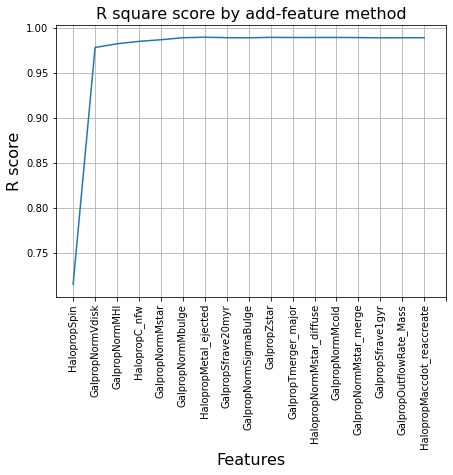

Elapsed time to run RF func on Disks: 6975.777 seconds


In [15]:
# this code takes ~2 hrs to run when the dataset is disk galaxies with ~15,000 entries
start_time = time.time()

disks_RF_results = target_predicting_RF_function(X, y)

elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF func on Disks: {elapsed_time:.3f} seconds")

In [25]:
disks_RF_results[3]

,0
HalopropSpin,2.030956
GalpropNormVdisk,0.440047
HalopropC_nfw,0.028724
GalpropNormMHII,0.009101
GalpropNormMH2,0.008877
GalpropNormMHI,0.002159
GalpropNormSigmaBulge,0.002157
GalpropNormMbulge,0.001784
GalpropNormMstar,0.001621
GalpropNormMcold,0.001447


In [22]:
disks_RF_results[4]

,feature_number,features,r_sq_score
0,1,HalopropSpin,0.714689
1,2,GalpropNormVdisk,0.978289
2,3,GalpropNormMHI,0.982399
3,4,HalopropC_nfw,0.985082
4,5,GalpropNormMstar,0.986926
5,6,GalpropNormMbulge,0.989127
6,7,HalopropMetal_ejected,0.989697
7,8,GalpropSfrave20myr,0.989189
8,9,GalpropNormSigmaBulge,0.989036
9,10,GalpropZstar,0.989564


In [23]:
disks_RF_results[5]

<AxesSubplot:title={'center':'R square score by add-feature method'}, xlabel='Features', ylabel='R score'>

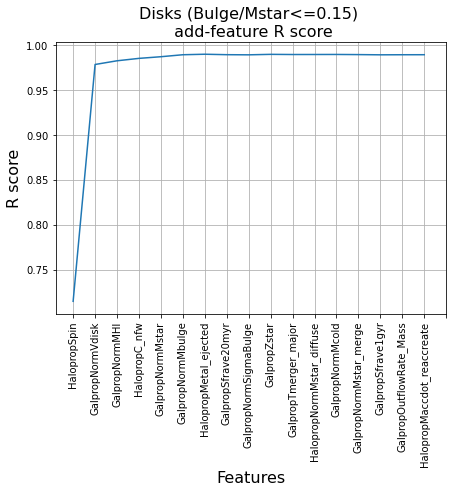

In [27]:
fig_add_feature=disks_RF_results[4].plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                    legend=False, grid=True, 
                    xticks=range(0,18))
fig_add_feature.set_title(label= 'Disks (Bulge/Mstar<=0.15) \n add-feature R score',fontsize=16)
fig_add_feature.set_xlabel('Features',fontsize=16)
fig_add_feature.set_ylabel('R score',fontsize=16)

# fig_add_feature.get_figure().savefig('Disks R score by add-feature method.jpg', dpi=500)

plt.show()

In [34]:
# disks_RF_results[4].to_csv('Disks Max r scores by add column method.csv', index=False)



In [35]:
# disks = pd.read_csv('Disks Max r scores by add column method.csv')

In [36]:
disks

,feature_number,features,r_sq_score
0,1,HalopropSpin,0.714689
1,2,GalpropNormVdisk,0.978289
2,3,GalpropNormMHI,0.982399
3,4,HalopropC_nfw,0.985082
4,5,GalpropNormMstar,0.986926
5,6,GalpropNormMbulge,0.989127
6,7,HalopropMetal_ejected,0.989697
7,8,GalpropSfrave20myr,0.989189
8,9,GalpropNormSigmaBulge,0.989036
9,10,GalpropZstar,0.989564


In [42]:
fig_disks = disks_RF_results[1]
fig_disks.savefig('Disks RF Prediction_vs_True.jpeg', dpi=500)
plt.show()


In [44]:
fig_builtin_imp = disks_RF_results[2]
fig_builtin_imp.savefig('Disks Built-in Feature Ranking.jpeg', dpi=500)
plt.show()

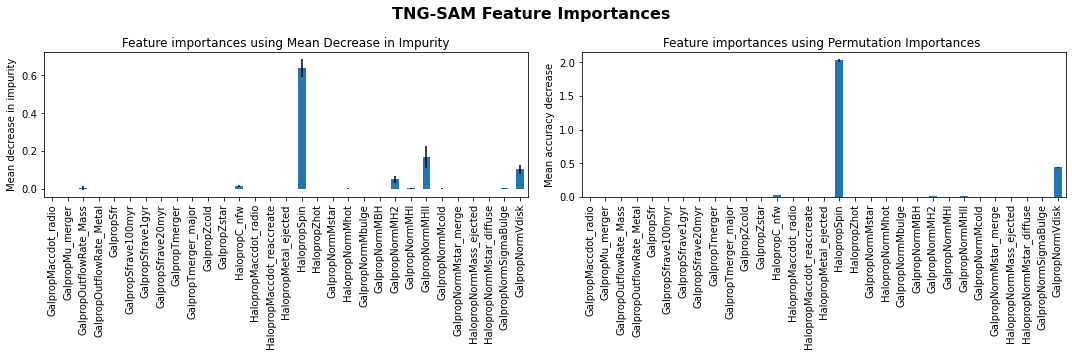

In [43]:
disks_RF_results[2]